In [1]:
import sklearn.model_selection
from sklearn.datasets import fetch_openml
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import numpy as np

X, y = fetch_openml(data_id=40691, as_frame=True, return_X_y=True)
y = np.array(y, dtype=int)

/usr/local/lib/python3.8/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
import autosklearn
from autosklearn.classification import AutoSklearnClassifier
import imblearn

In [3]:
from pprint import pprint

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Problem statement

Given the dataset, a Random Forest (RF) model with default parameters performs much better (~7%) than the model found by `autosklearn` which involves pipeline optimization. This is unexpected since a tuned pipeline is supposed to perform as good as the default RF if not better. We are investigating the cause of this issue.

# Data evaluation

First, the data quality will be evaluated. Since the objective is to classify the quality of wine based on the feature columns, I mostly focus on three main factors:
1. missing data
2. data skewness
3. data imbalance

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
dtypes: float64(11)
memory usage: 137.5 KB


In [6]:
X.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


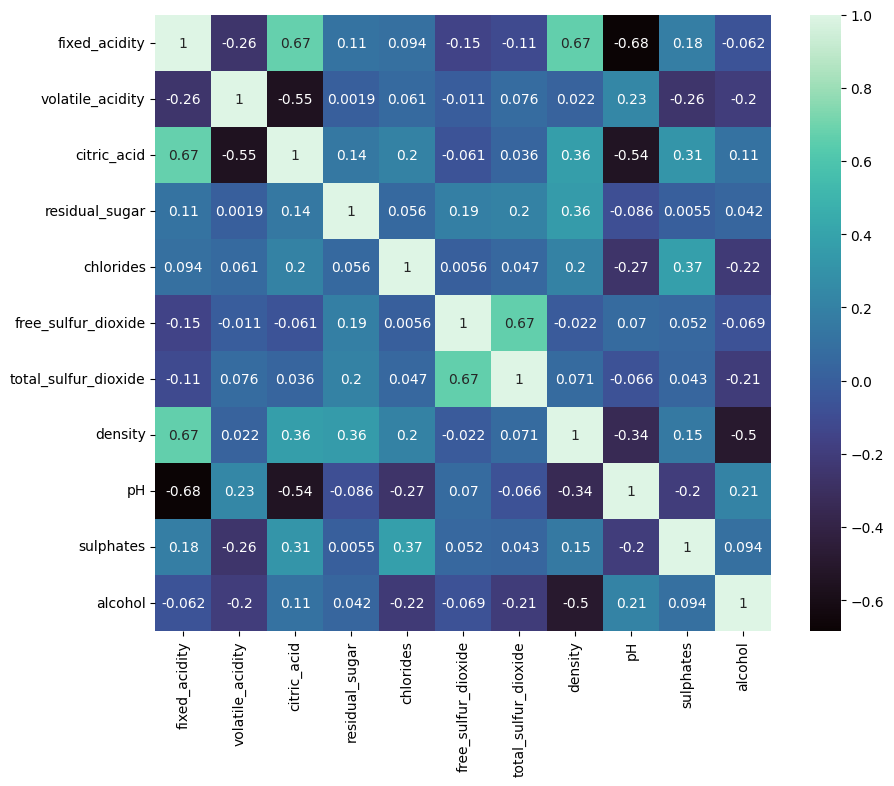

In [7]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(X.corr(), annot=True, square=True, cmap='mako')

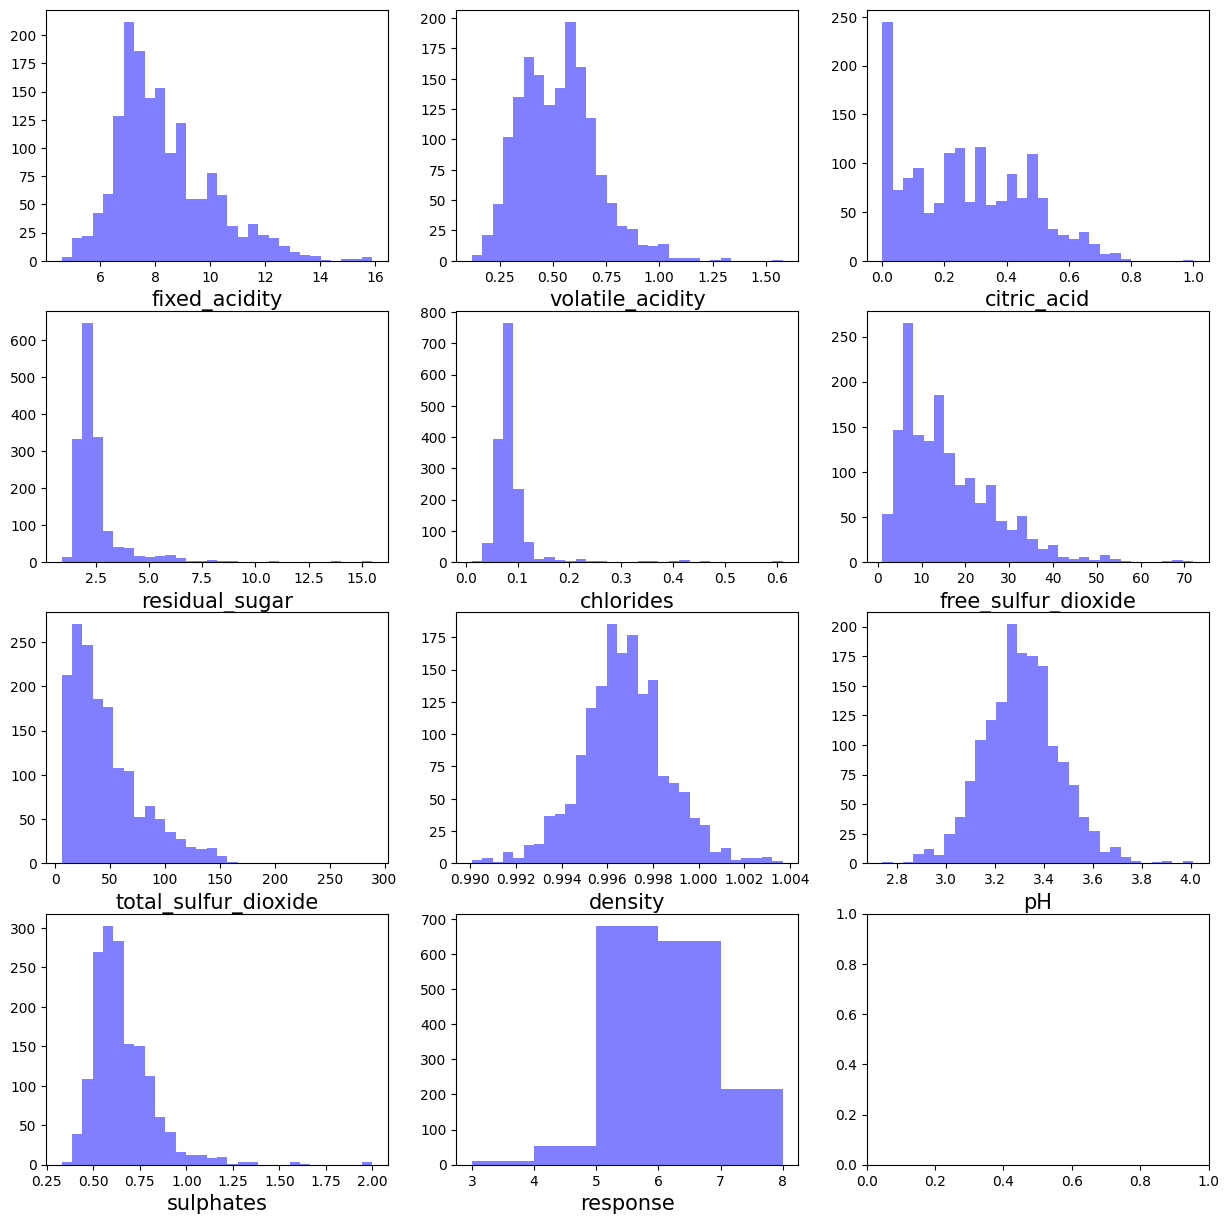

In [8]:
fig, ax = plt.subplots(4, 3, figsize=(15, 15))
ax = ax.ravel()
for i, feature in enumerate(X.columns[:-1]):
    ax[i].hist(X[feature], bins=30, color='b', alpha=0.5)
    ax[i].set_xlabel(feature, fontsize=15)
ax[i+1].hist(y, color='b', alpha=0.5, bins=np.arange(min(y), max(y)+1))
ax[i+1].set_xlabel("response", fontsize=15)
plt.show()

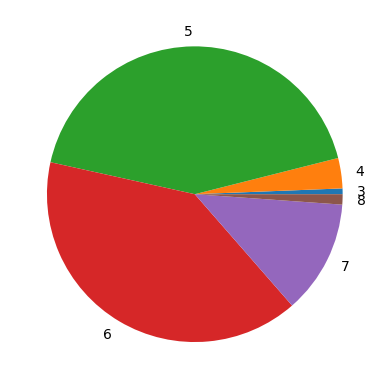

[3 4 5 6 7 8] [ 10  53 681 638 199  18]


In [9]:
uni, counts = np.unique(y, return_counts=True)
plt.pie(counts, labels=uni) 
plt.show()
print(uni, counts)

# Issues with the dataset

The dataset does not have missing values and there is no strong correlation between features. However, the dataset has two obvious issues:

1. skewed explanatory variables (features) with outliers
2. imbalanced class

The dataset has extremely imbalanced classes with minority classes 3, 4, 8 having less than 0.05 ratio to majority class. I choose to use Synthetic Minority Oversampling Technique (SMOTE) to oversample the minority class followed by undersampling with Tomek links. The oversampling is to ensure a balanced dataset and the undersampling is to reduce the effects of outliers on the dataset itself. To solve the skewed features, I choose to use scalers to scale them and reduce the effect of outliers. The scaler is applied first and then balancing techniques are applied on the dataset.

Results are shown below

In [10]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler

Standard Scaler


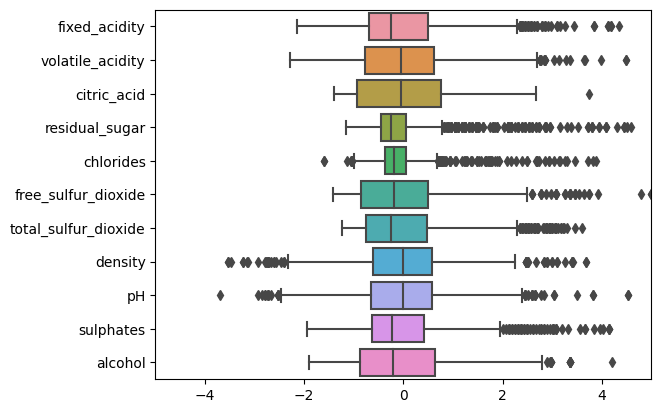

Power transformer


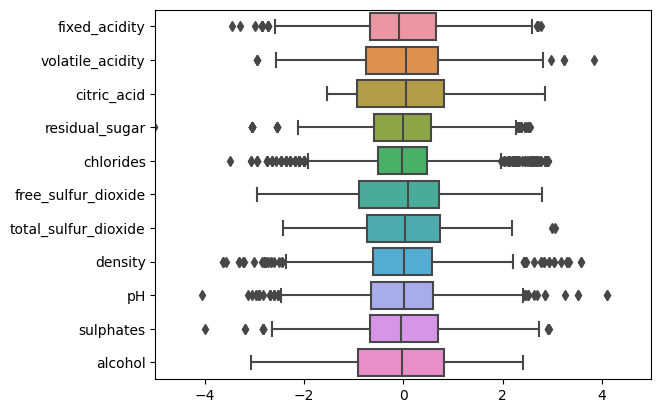

Robust Scaler


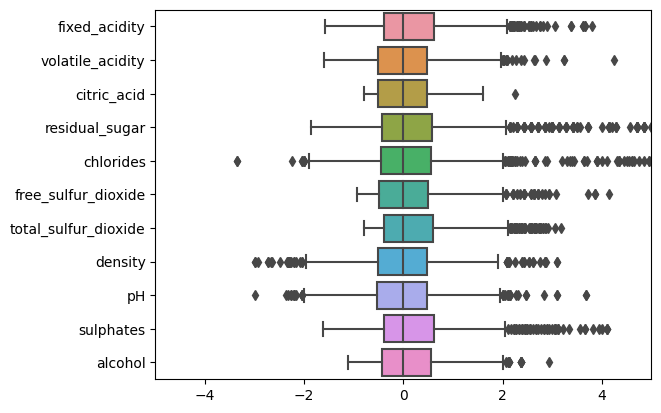

In [11]:
print("Standard Scaler")
ax = sns.boxplot(StandardScaler().fit_transform(X), orient='h' )
ax.set_yticklabels(X.columns)
ax.set_xlim([-5, 5])
plt.show()

print("Power transformer")
ax = sns.boxplot(PowerTransformer().fit_transform(X), orient='h' )
ax.set_yticklabels(X.columns)
ax.set_xlim([-5, 5])
plt.show()

print("Robust Scaler")
ax = sns.boxplot(RobustScaler().fit_transform(X), orient='h' )
ax.set_yticklabels(X.columns)
ax.set_xlim([-5, 5])
plt.show()

# Scaler results


From plots above, we can see that power transformer performs the best in terms of treating outliers. However, it does not accurately reflect the variance of some catagories. I choose robust scaler to perform the preprocessing.
However, to better illustrate what autosklearn can do for pipeline optimization, I will not use scaling on the dataset for autosklearn training since autosklearn has an internal data preprocessor.

# Solving the imbalanced classes issue

To solve the imbalanced classes, I first oversample the minority class so the ratio between all minority classes to majority class is about 1:3. The reason to choose this ratio is because the minority classes have very limited number of samples. The more data we oversample, the more noises and biases we introduce to the dataset. This can very likely reduce the generalizability of the model in long run. After oversampling, I undersample the data to draw majority and minority class closer while reducing the effect of outliers. This is achieved with SMOTE and Tomek links (SMOTETomek).

In [12]:
from imblearn.combine import SMOTETomek

In [13]:
# X_samp, y_samp = SMOTETomek(random_state=42, sampling_strategy='auto').fit_resample(X, y)
samp_count = {
    3: 200,
    4: 200,
#     5: 200,
#     6: 200,
#     7: 200,
    8: 200
}
X_samp, y_samp = SMOTETomek(random_state=42, sampling_strategy=samp_count).fit_resample(X, y)

In [14]:
list(zip(*np.unique(y, return_counts=True)))

[(3, 10), (4, 53), (5, 681), (6, 638), (7, 199), (8, 18)]

In [15]:
list(zip(*np.unique(y_samp, return_counts=True)))

[(3, 197), (4, 181), (5, 599), (6, 546), (7, 167), (8, 188)]

In [16]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_samp, y_samp, random_state=42)

In [17]:
rb = RobustScaler().fit(X_train)
X_train_trans = rb.transform(X_train)
X_test_trans = rb.transform(X_test)

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
clf = RandomForestClassifier(random_state=42)
clf = clf.fit(X_train, y_train)
# y_hat = clf.predict(X_test_trans)
# sklearn.metrics.accuracy_score(y_test, y_hat)
print("RF Accuracy no scaler", clf.score(X_test, y_test))

clf = clf.fit(X_train_trans, y_train)
# y_hat = clf.predict(X_test_trans)
# sklearn.metrics.accuracy_score(y_test, y_hat)
print("RF Accuracy with scaler", clf.score(X_test_trans, y_test))

RF Accuracy no scaler 0.7893617021276595
RF Accuracy with scaler 0.7957446808510639


In [20]:
scorer = autosklearn.metrics.balanced_accuracy
automl = AutoSklearnClassifier(time_left_for_this_task=600,
                               per_run_time_limit=60,
                               n_jobs=5,
                               seed=42,
#                               include = {
#                                             'classifier': ["random_forest"],
#                                             'feature_preprocessor': ["no_preprocessing"]
#                                         },
                               resampling_strategy="cv",
                               resampling_strategy_arguments={"train_size": 0.67,     # The size of the training set
                                                                "shuffle": True,        # Whether to shuffle before splitting data
                                                                "folds": 3    },
                               metric=scorer
                              )
automl.fit(X_train, y_train)
# y_hat = automl.predict(X_test_trans)
print("AutoML Accuracy", automl.score(X_test, y_test))

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


[WARNING] [2024-04-19 20:28:57,721:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-04-19 20:29:02,076:Client-EnsembleBuilder] No runs were available to build an ensemble from
AutoML Accuracy 0.7933291289423364


In [21]:
print(automl.leaderboard())

          rank  ensemble_weight           type      cost   duration
model_id                                                           
56           1             0.02  random_forest  0.268290  25.039412
10           2             0.02    extra_trees  0.271283  24.027745
2            3             0.02  random_forest  0.283017  31.142734
12           4             0.02  random_forest  0.293370  28.993769
61           5             0.02  random_forest  0.328154  22.705714
66           6             0.84            sgd  0.551302  20.404926
29           7             0.06            sgd  0.747395   9.561666


In [22]:
# # X_all = PowerTransformer().fit_transform(X_samp)
clf = RandomForestClassifier(random_state=42)
scorer = autosklearn.metrics.balanced_accuracy
automl = AutoSklearnClassifier(time_left_for_this_task=300,
                               per_run_time_limit=30,
                               n_jobs=5,
                               seed=42,
#                               include = {
#                                             'classifier': ["random_forest"],
#                                             'feature_preprocessor': ["no_preprocessing"]
#                                         },
                               resampling_strategy="cv",
                               resampling_strategy_arguments={"train_size": 0.7,     # The size of the training set
                                                                "shuffle": True,        # Whether to shuffle before splitting data
                                                                "folds": 3    },
                               metric=scorer
                              )
rf_scores = cross_val_score(clf, X_samp, y_samp, cv=5)
automl_scores = cross_val_score(automl, X_samp, y_samp, cv=5)
print("RF CV mean:", np.mean(rf_scores), "\nAutoML CV mean:", np.mean(automl_scores))

[WARNING] [2024-04-19 20:39:26,101:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-04-19 20:39:52,889:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-04-19 20:39:53,084:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-04-19 20:39:57,494:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-04-19 20:39:57,768:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-04-19 20:40:02,478:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-04-19 20:40:02,995:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-04-19 20:40:06,926:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-04-19 20:40:07,379:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-04-19 20:40:

# Results and Discussions

There are two tests done to compare the performance of default RF and autosklearn model. The first one is a single train and test split to show the performance difference with a single dataset. The second test is to do a 5-fold CV on both models to get a more unbiased evaluation of them.

Both tests show that autosklearn model performs slightly better than default RF model does. Many experiments on autosklearn package were conducted to find the reasons. Mainly, I added resampling strategy and changed the evaluation metric. Since our purpose is to optimize the inference accuracy, I set the metric to `balanced_accuracy`. I also added 3-fold CV as the resampling method to ensure better generalizability and minimize overfitting. The ensemble models of autosklearn results show that tree-based methods perform very well, which explains why the default RF already has a good performance.

I also tried oversampling-only method that oversampled minority classes to have the same number of observations as the majority classes. Although both methods had high accuracy on the testing dataset, I think the performance might not be reliable so I decided to oversample them with lower counts for generalizability.

In conclusion, the two main issues: 1. issue that skewed features with outliers can be solved by autosklearn's internal data preprocessor and 2. issue with the imbalanced classes are solved with over- and undersampling with SMOTETomek. After these two steps, the performance of autosklearn is better than default RF model.

# References

- https://machinelearningmastery.com/multi-class-imbalanced-classification/
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/